In [116]:

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb


from catboost import CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import clone


# 準備

In [147]:
"""データの読込"""
# 欠損値ありデータ
# train_df = pd.read_csv("../data/train.csv", index_col=0)
# test_df  = pd.read_csv("../data/test.csv", index_col=0)

# 欠損値なしデータ
train_df = pd.read_csv("../data/train_imputed_with_lgbm.csv", index_col=0)
test_df  = pd.read_csv("../data/test_imputed_with_lgbm.csv", index_col=0)

train_df.head()

,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,6,0.1691,652.10,29579.74,10.66,730,3333,4955.0,39.6,4,2,0,1
1,5,0.1354,191.27,52808.95,13.06,707,6063,12335.0,37.8,2,1,0,0
2,1,0.0758,377.00,168689.22,11.98,736,2681,1505.0,5.0,1,0,0,0
3,2,0.1774,359.33,71325.19,20.55,702,3972,39536.0,94.1,1,0,0,0
4,1,0.1430,875.45,130773.88,17.61,688,5555,17295.0,56.4,0,0,0,0


In [118]:
"""データの基本情報"""

print(f"訓練データセットの形状： {train_df.shape}")
print(f"テストデータセットの形状： {test_df.shape}")

print()
print("===基本統計量===")
print("<訓練データセット>")
display(train_df.describe())
print("<最終テストデータセット>")
display(test_df.describe())


print()
print("===要約情報===")
print("<訓練データセット>")
display(train_df.info())
print("<最終テストデータセット>")
display(test_df.info())

訓練データセットの形状： (40785, 13)
テストデータセットの形状： (40786, 12)

===基本統計量===
<訓練データセット>


,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,40785.000000,40785.000000,40785.000000,4.078500e+04,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000
mean,2.747628,0.125414,302.319235,7.087001e+04,12.530579,709.393061,4736.481746,15426.025468,46.161957,1.543018,0.180998,0.039696,0.151870
std,1.986736,0.030167,208.058959,6.524275e+04,6.831929,39.299297,2568.216636,22343.495560,28.258810,2.059082,0.513544,0.195246,0.358899
min,0.000000,0.060800,15.680000,2.086720e+03,0.110000,615.000000,179.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.105300,157.400000,3.868640e+04,6.700000,679.000000,2965.000000,3433.000000,22.500000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.125200,241.120000,5.862029e+04,12.740000,703.000000,4304.000000,8441.000000,44.500000,1.000000,0.000000,0.000000,0.000000
75%,4.000000,0.145100,391.990000,8.416863e+04,17.930000,737.000000,5896.000000,19085.000000,68.900000,2.000000,0.000000,0.000000,0.000000
max,6.000000,0.800000,939.380000,1.913363e+06,29.930000,826.000000,16888.000000,356328.000000,108.300000,14.000000,3.000000,1.000000,1.000000


<最終テストデータセット>


,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
count,40786.000000,40786.00000,40786.000000,4.078600e+04,40786.000000,40786.000000,40786.000000,40786.000000,40786.00000,40786.00000,40786.000000,40786.000000
mean,2.758888,0.12544,300.571366,7.019006e+04,12.552485,709.242338,4685.578556,15249.182289,46.41177,1.52876,0.179694,0.038739
std,1.980095,0.03087,208.171846,6.145846e+04,6.836684,39.320390,2540.021093,22272.133847,28.32093,2.08263,0.513398,0.192974
min,0.000000,0.06160,15.680000,2.128340e+03,0.090000,616.000000,181.000000,1.000000,0.10000,0.00000,0.000000,0.000000
25%,1.000000,0.10540,155.790000,3.855412e+04,6.700000,679.000000,2928.250000,3367.000000,23.00000,0.00000,0.000000,0.000000
50%,2.000000,0.12510,240.400000,5.814888e+04,12.760000,704.000000,4253.000000,8258.000000,44.70000,1.00000,0.000000,0.000000
75%,4.000000,0.14510,388.415000,8.379708e+04,17.950000,736.750000,5834.000000,18686.750000,69.10000,2.00000,0.000000,0.000000
max,6.000000,0.90000,938.860000,2.000790e+06,29.950000,826.000000,17416.000000,296156.000000,109.60000,14.00000,3.000000,1.000000



===要約情報===
<訓練データセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40785 entries, 0 to 40784
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40785 non-null  int64  
 1   int.rate           40785 non-null  float64
 2   installment        40785 non-null  float64
 3   annual.inc         40785 non-null  float64
 4   dti                40785 non-null  float64
 5   fico               40785 non-null  int64  
 6   days.with.cr.line  40785 non-null  int64  
 7   revol.bal          40785 non-null  float64
 8   revol.util         40785 non-null  float64
 9   inq.last.6mths     40785 non-null  int64  
 10  delinq.2yrs        40785 non-null  int64  
 11  pub.rec            40785 non-null  int64  
 12  not.fully.paid     40785 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 4.4 MB


None

<最終テストデータセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40786 entries, 40785 to 81570
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40786 non-null  int64  
 1   int.rate           40786 non-null  float64
 2   installment        40786 non-null  float64
 3   annual.inc         40786 non-null  float64
 4   dti                40786 non-null  float64
 5   fico               40786 non-null  int64  
 6   days.with.cr.line  40786 non-null  int64  
 7   revol.bal          40786 non-null  float64
 8   revol.util         40786 non-null  float64
 9   inq.last.6mths     40786 non-null  int64  
 10  delinq.2yrs        40786 non-null  int64  
 11  pub.rec            40786 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 4.0 MB


None

# 前処理

### 関数

In [148]:
"""データの変換（標準化・対数変換・OneHotエンコーディング）"""
# purposeのOne-Hotエンコーディング
    # train
dummy_df = pd.get_dummies(
    train_df["purpose"],
    prefix="purpose",
    prefix_sep="_",
    drop_first=True, # k-1個のダミー変数を作成するかどうか（多重共線性の軽減）
)

# 列（横）方向に結合
train_df = pd.concat([train_df, dummy_df], axis=1).drop(columns="purpose")

    # test
dummy_df = pd.get_dummies(
    test_df["purpose"],
    prefix="purpose",
    prefix_sep="_",
    drop_first=True, # k-1個のダミー変数を作成するかどうか（多重共線性の軽減）
)

# 列（横）方向に結合
test_df = pd.concat([test_df, dummy_df], axis=1).drop(columns="purpose")

In [149]:
# 数値データの標準化
# 数値データの列名
num_col = ["int.rate", "installment", "dti", "fico", "days.with.cr.line", "revol.util"]

# 標準化のためのインスタンス作成
scaler = StandardScaler()

train_df[num_col] = scaler.fit_transform(train_df[num_col])
test_df[num_col] = scaler.transform(test_df[num_col])

In [150]:
# annual.inc の対数変換
train_df["annual.inc"] =  np.log(train_df["annual.inc"])
test_df["annual.inc"] = np.log(test_df["annual.inc"])

train_df["revol.val"] = np.log(train_df["revol.bal"])
test_df["revol.val"] = np.log(test_df["revol.bal"])

In [151]:
train_df.head()

,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,revol.val
0,1.448186,1.681182,10.294845,-0.273803,0.524365,-0.546488,4955.0,-0.232212,4,2,0,1,0,0,0,0,0,1,8.508152
1,0.331043,-0.533746,10.874436,0.077493,-0.060894,0.516520,12335.0,-0.295910,2,1,0,0,0,0,0,0,1,0,9.420196
2,-1.644678,0.358945,12.035813,-0.080590,0.677042,-0.800364,1505.0,-1.456624,1,0,0,0,1,0,0,0,0,0,7.316548
3,1.723329,0.274016,11.175005,1.173829,-0.188124,-0.297674,39536.0,1.696414,1,0,0,0,0,1,0,0,0,0,10.584967
4,0.582980,2.754689,11.781225,0.743492,-0.544369,0.318715,17295.0,0.362300,0,0,0,0,1,0,0,0,0,0,9.758173


In [152]:
"""データの分割"""

# 説明変数/目的変数の分割
X = train_df.drop(columns=["not.fully.paid"])
y = train_df["not.fully.paid"]

# モデルの構築（LightGBM）

### 関数

In [153]:
"""構築された任意のモデルの出力が，閾値ごとにどう精度が変動するか？また，混同行列による可視化をする関数"""

def view_performance(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
):
    # 1（未払い）である確率値を取得
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]

    # 最もAUCスコアが高くなる閾値の取得&可視化
    best_thr = show_lineplt(
        y_prob_train=y_prob_train,
        y_prob_test=y_prob_test,
        y_train=y_train,
        y_test=y_test
    )

    # 混合行列の表示
    show_cm(
        best_thr=best_thr,
        y_prob_train=y_prob_train,
        y_prob_test=y_prob_test,
        y_train=y_train,
        y_test=y_test
    )



# 折れ線グラフ
def show_lineplt(
    y_prob_train,
    y_prob_test,
    y_train,
    y_test,
):
    # 0.1〜0.9の範囲の閾値に対するaucの変動の可視化
    thresholds = np.arange(0.1, 1.0, 0.1)

    # 各閾値におけるAUCスコアを格納するリスト
    auc_scores_train = []
    auc_scores_test = []

    # 最適な閾値を取得するための変数
    max_auc_score = 0
    best_thr = 0

    for thr in thresholds:
        # 閾値を上回る場合に1を割り当てる
        y_pred_train = (y_prob_train > thr).astype(int)
        y_pred_test = (y_prob_test > thr).astype(int)

        # AUCスコアの算出
        auc_train = roc_auc_score(y_true=y_train, y_score=y_pred_train)
        auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test)

        auc_scores_train.append(auc_train)
        auc_scores_test.append(auc_test)

        if auc_test > max_auc_score:
            max_auc_score = auc_test
            best_thr = thr

    # グラフのプロット
    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, auc_scores_train, label="Train AUC score", color="blue")
    plt.plot(thresholds, auc_scores_test, label="Test AUC score", color="red")
    plt.xlabel("Threshold")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_thr

def show_cm(
    best_thr,
    y_prob_train,
    y_prob_test,
    y_train,
    y_test,
):
    # 予測の二値化
    y_pred_train = (y_prob_train > best_thr).astype(int)
    y_pred_test = (y_prob_test > best_thr).astype(int)

    # 混合行列の作成
    conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
    conf_matrix_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

    # 混合行列のヒートマッププロット
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # トレーニングデータの混合行列
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='binary', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix\nThreshold = {best_thr}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # テストデータの混合行列
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='binary', ax=axes[1])
    axes[1].set_title(f'Test Confusion Matrix\nThreshold = {best_thr}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 混合行列の割合計算
    conf_matrix_train_norm = conf_matrix_train / conf_matrix_train.sum()
    conf_matrix_test_norm = conf_matrix_test / conf_matrix_test.sum()

    # 混合行列のヒートマッププロット
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # トレーニングデータの混合行列（割合）
    sns.heatmap(conf_matrix_train_norm, annot=True, fmt='.2%', cmap='binary', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix (Normalized)\nThreshold = {best_thr}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # テストデータの混合行列（割合）
    sns.heatmap(conf_matrix_test_norm, annot=True, fmt='.2%', cmap='binary', ax=axes[1])
    axes[1].set_title(f'Test Confusion Matrix (Normalized)\nThreshold = {best_thr}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 訓練
    cal_score(
        cm=conf_matrix_train,
        y_true=y_train,
        y_pred=y_pred_train,
        phase="train",
    )
    # テスト
    cal_score(
        cm=conf_matrix_test,
        y_true=y_test,
        y_pred=y_pred_test,
        phase="test",
    )


# Accuracy, Precision, Recall, F1スコア, ROC_AUCスコアの算出
def cal_score(
    cm, # 混合行列
    y_true, # 正解ラベル
    y_pred, # 予測値
    phase="train",
):
    tn, fp, fn, tp = cm.ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc_score = roc_auc_score(y_true=y_true, y_score=y_pred)

    print(f"---{phase}---")
    print(f'Accuracy: {acc}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}\nauc_score: {auc_score}\n\n')

### 前処理なし

In [170]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# LightGBM ハイパーパラメータグリッド
param_grid = {
    "num_leaves": [3],
    "learning_rate": [0.1],
    "n_estimators": [450],
    "lambda_l1": [0.1],
    "lambda_l2": [0.5],
    "verbosity": [-1],
}

# カスタムスコアラーを作成
scorer = make_scorer(roc_auc_score, needs_proba=True)

# GridSearchCVの設定
lgb_estimator = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    force_row_wise=True
)

grid_search = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    verbose=0,
)

# グリッドサーチの実行
grid_search.fit(
    X_train,
    y_train
)

# 最良モデルのパラメータ表示
display(pd.DataFrame(data=[grid_search.best_params_]))

,lambda_l1,lambda_l2,learning_rate,n_estimators,num_leaves,verbosity
0,0.1,0.5,0.1,450,3,-1


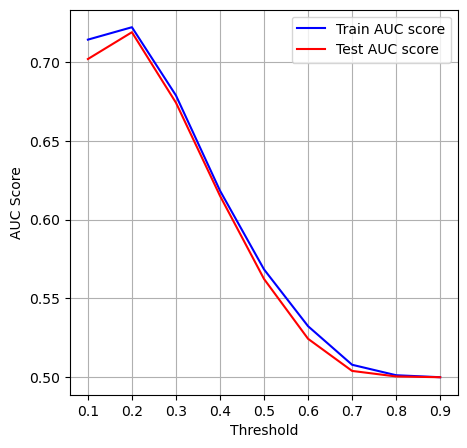

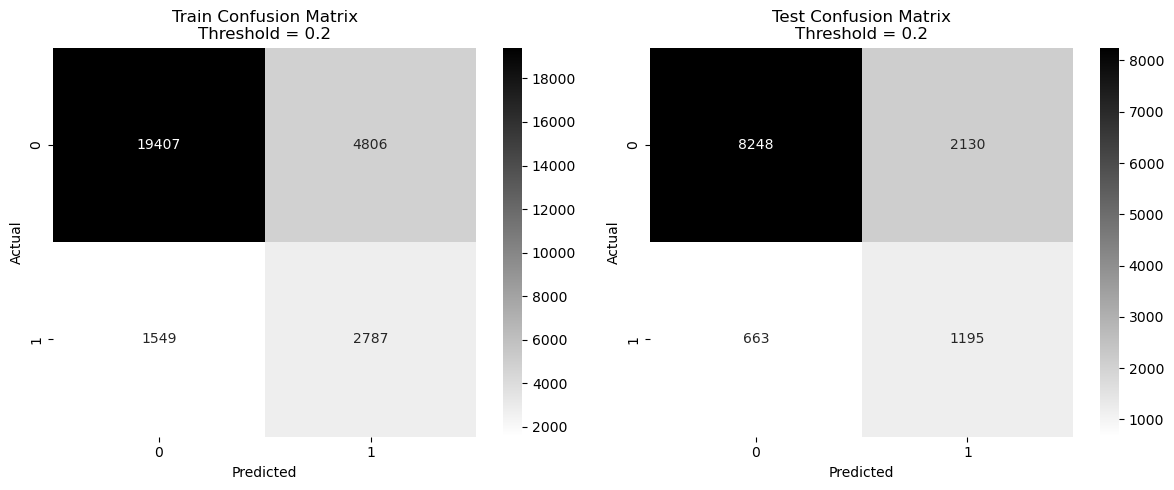

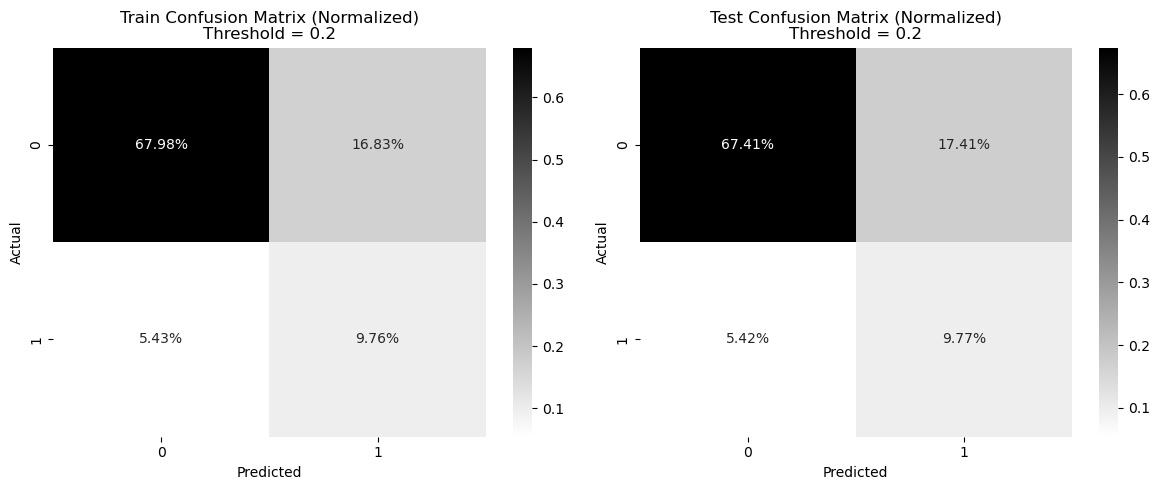

---train---
Accuracy: 0.7774002592034748
precision: 0.36704859739233503
recall: 0.6427583025830258
f1: 0.4672646491742811
auc_score: 0.7221349436344693


---test---
Accuracy: 0.7717391304347826
precision: 0.3593984962406015
recall: 0.6431646932185145
f1: 0.4611229017943276
auc_score: 0.718961417721225




In [171]:
# モデルの評価
view_performance(
    grid_search.best_estimator_,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

### Weightオプションの設定

In [175]:
from sklearn.utils.class_weight import compute_sample_weight
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# サンプルの重みを計算
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')

# LightGBM ハイパーパラメータグリッド
param_grid = {
    "num_leaves": [5],
    "learning_rate": [0.1],
    "n_estimators": [200],
    "lambda_l1": [0.25],
    "lambda_l2": [0.5],
    "verbosity": [-1],
}

# カスタムスコアラーを作成
scorer = make_scorer(roc_auc_score, needs_proba=True)

# GridSearchCVの設定
lgb_estimator = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    force_row_wise=True
)

grid_search = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    verbose=0,
)

# グリッドサーチの実行
grid_search.fit(
    X_train,
    y_train,
    sample_weight=train_weight,
)

# 最良モデルのパラメータの表示
display(pd.DataFrame(data=[grid_search.best_params_]))


,lambda_l1,lambda_l2,learning_rate,n_estimators,num_leaves,verbosity
0,0.25,0.5,0.1,200,5,-1


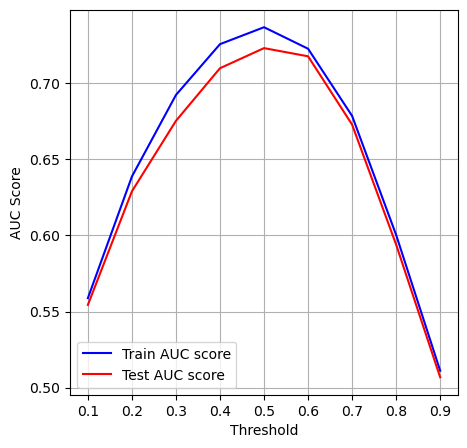

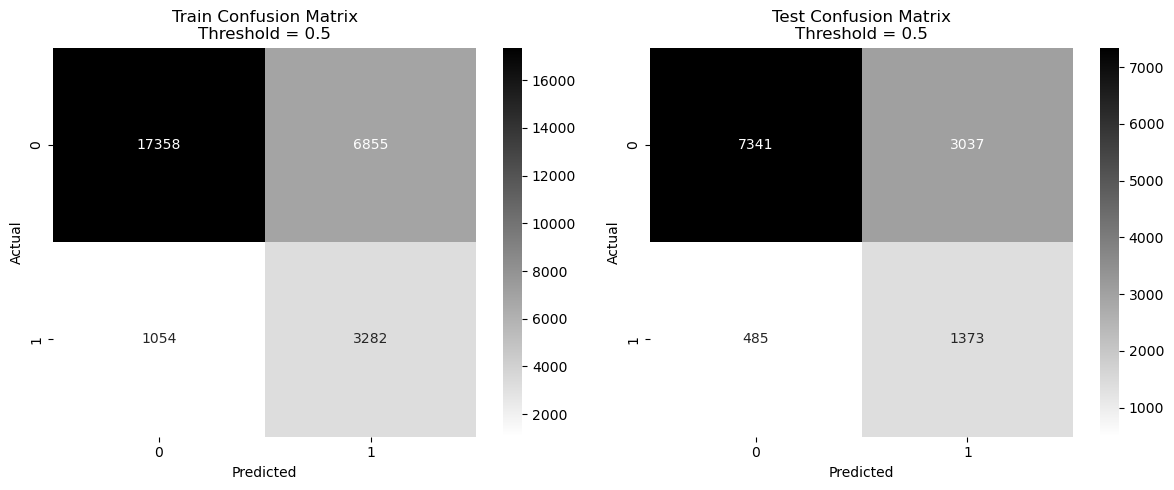

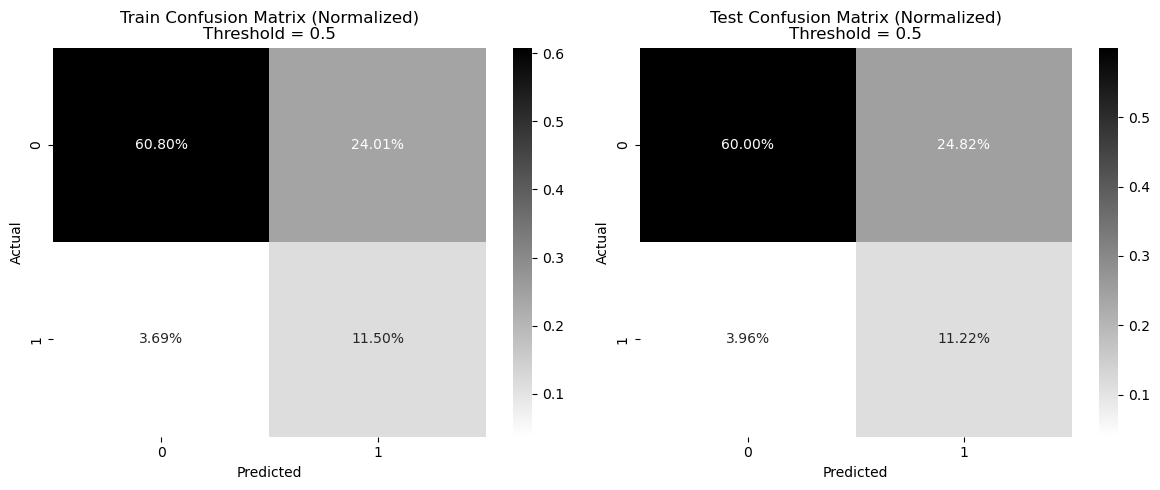

---train---
Accuracy: 0.7229675295106659
precision: 0.3237644273453685
recall: 0.7569188191881919
f1: 0.4535341670697161
auc_score: 0.7369032207699105


---test---
Accuracy: 0.7121608368747957
precision: 0.31133786848072564
recall: 0.7389666307857912
f1: 0.4380982769623485
auc_score: 0.7231641787577058




In [176]:
# モデルの評価
view_performance(
    grid_search.best_estimator_,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

### UnderSampling

In [180]:
from imblearn.under_sampling import RandomUnderSampler
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# UnderSamplingインスタンスの作成
rus = RandomUnderSampler(random_state=42, replacement=True)
print(f"Underサンプリング前: {X_train.shape}")
X_train, y_train = rus.fit_resample(X_train, y_train)
print(f"Underサンプリング後: {X_train.shape}")

# LightGBM ハイパーパラメータグリッド
param_grid = {
    "num_leaves": [10],
    "learning_rate": [0.1],
    "n_estimators": [300],
    "lambda_l1": [0.25],
    "lambda_l2": [0.5],
    "verbosity": [-1],
}

# カスタムスコアラーを作成
scorer = make_scorer(roc_auc_score, needs_proba=True)

# GridSearchCVの設定
lgb_estimator = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    force_row_wise=True
)

grid_search = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    verbose=0,
)

# グリッドサーチの実行
grid_search.fit(
    X_train,
    y_train,
)

# 最良モデルのパラメータの表示
display(pd.DataFrame(data=[grid_search.best_params_]))


Underサンプリング前: (28549, 18)
Underサンプリング後: (8672, 18)


,lambda_l1,lambda_l2,learning_rate,n_estimators,num_leaves,verbosity
0,0.25,0.5,0.1,300,10,-1


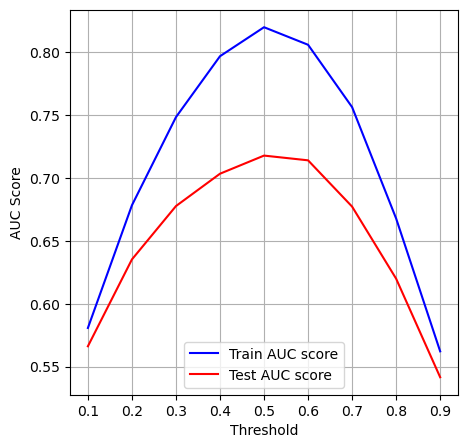

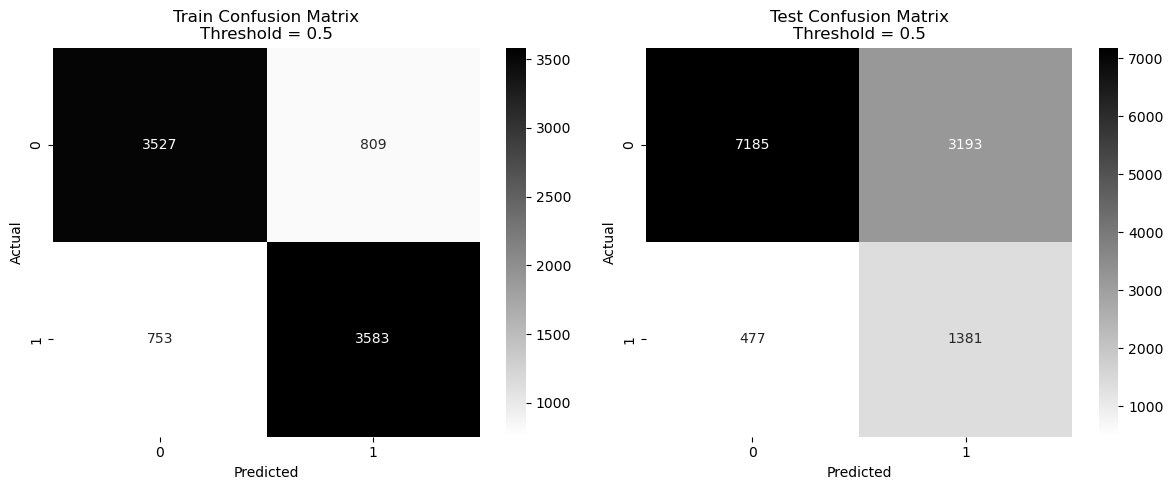

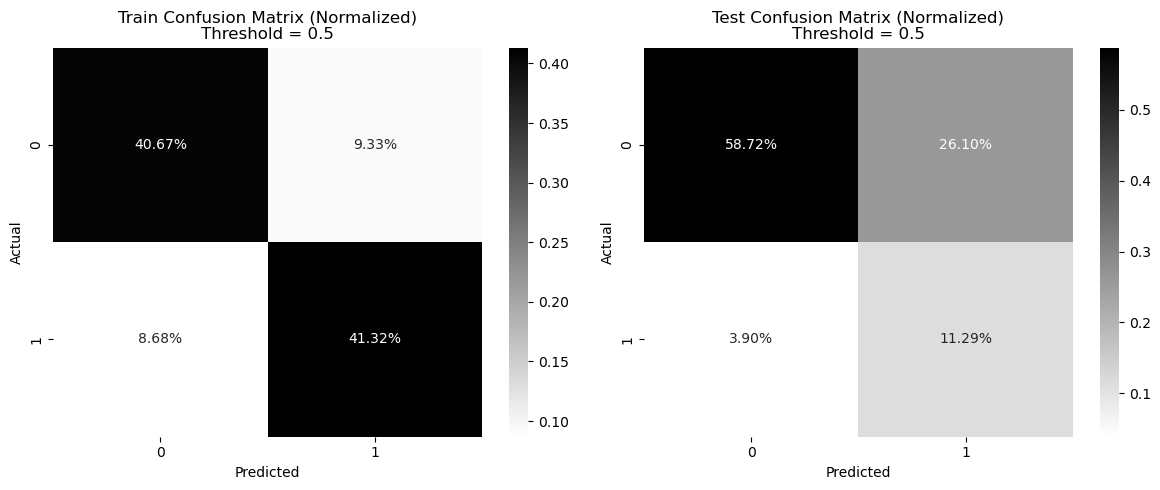

---train---
Accuracy: 0.819880073800738
precision: 0.8158014571948998
recall: 0.8263376383763837
f1: 0.8210357470210816
auc_score: 0.819880073800738


---test---
Accuracy: 0.7000653808434129
precision: 0.3019239177962396
recall: 0.7432723358449946
f1: 0.4294154228855721
auc_score: 0.7178011322701559




In [181]:
# モデルの評価
view_performance(
    grid_search.best_estimator_,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

### UnderSampling + bagging

In [182]:
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# UnderSamplingインスタンスの作成
rus = RandomUnderSampler(random_state=42, replacement=True)
print(f"Underサンプリング前: {X_train.shape}")
X_train, y_train = rus.fit_resample(X_train, y_train)
print(f"Underサンプリング後: {X_train.shape}")

# LightGBM ハイパーパラメータグリッド
param_grid = {
    "base_estimator__num_leaves": [5, 10],
    "base_estimator__learning_rate": [0.25],
    "base_estimator__n_estimators": [250, 300, 400],
    "base_estimator__lambda_l1": [0.25],
    "base_estimator__lambda_l2": [0.5],
    "base_estimator__verbosity": [-1],
    "n_estimators": [20, 25, 50]  # バギングする際のツリーの数
}

# カスタムスコアラーを作成
scorer = make_scorer(roc_auc_score, needs_proba=True)

# LightGBMモデルの作成
lgb_estimator = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    force_row_wise=True
)

# BaggingClassifierの設定
bagging_estimator = BaggingClassifier(base_estimator=lgb_estimator, random_state=42)

# GridSearchCVの設定
grid_search = GridSearchCV(
    estimator=bagging_estimator,
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    verbose=0,
)

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

# 最良モデルのパラメータの表示
display(pd.DataFrame(data=[grid_search.best_params_]))


Underサンプリング前: (28549, 18)
Underサンプリング後: (8672, 18)


/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version

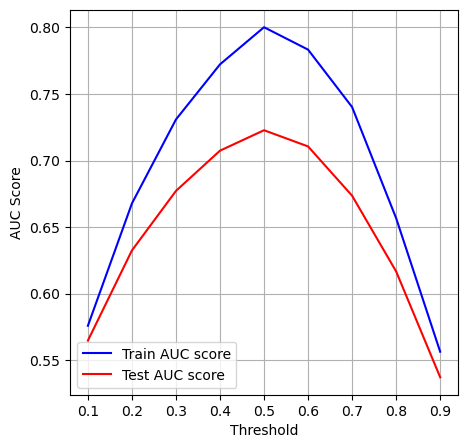

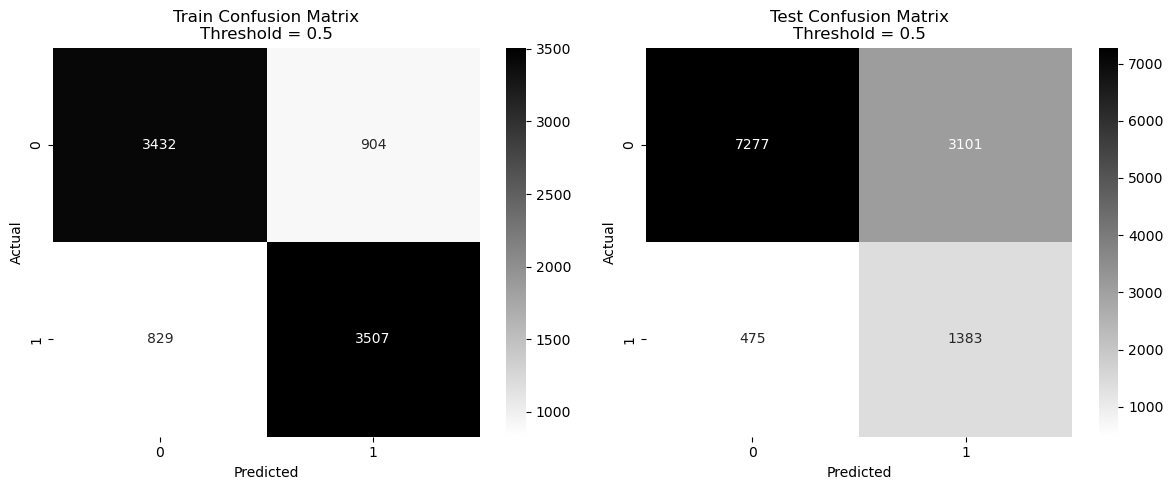

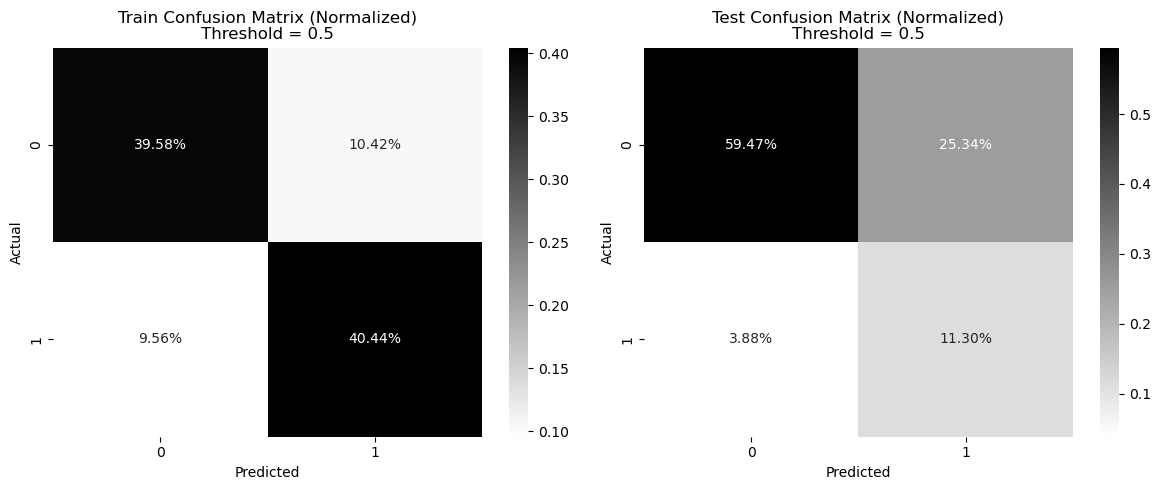

---train---
Accuracy: 0.8001614391143912
precision: 0.7950578100204035
recall: 0.808809963099631
f1: 0.8018749285469304
auc_score: 0.8001614391143912


---test---
Accuracy: 0.7077476299444263
precision: 0.3084299732381802
recall: 0.7443487621097955
f1: 0.43614001892147586
auc_score: 0.7227717986690816




In [27]:
# モデルの評価
view_performance(
    grid_search.best_estimator_,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)